In [1]:
import pandas as pd
import numpy as np
import MySQLdb
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np

In [2]:
db = MySQLdb.connect(host='104.154.94.28',db='loganp',\
                     read_default_file="~/.my.cnf",\
                     autocommit=True,\
                     local_infile = 1)
c=db.cursor()

In [3]:
def get_targets(ra,dec,ang_diam,project,name,dist=5000,con=db,database='master_gaia_database'):
    """
    Given an RA/Dec array of any size, returns a Pandas databse of
    the targets from the master database that fall within 
    a circle of specified angular diameter of the given RA/Decs
    All angles in degrees
    Args:
        ra,dec (array, float [deg]): arrays of pointing coordinates in decimal degrees
        ang_diam (float [deg]): angular size of the diameter of the beam you are simulating.  Default of 0.8 deg
                          is slightly smaller than the MeerKAT beam in L-band to provide a conservative estimate
        project (string): project name that this pointing came from
        name (string): name of the primary beam target
        dist (float, [pc]): depth of the desired query in parsecs.  Default is set larger than the largest distance
                          in the master database to return essentially no distance cut
        con (MySQL connection object): the connection you would like to use for the retrieval
        database (str): the database to query.  Default is the master database of all Gaia targets in our program
    Returns:
        Pandas dataframe of every object in the database meeting criteria
    """
    index = range(len(ra))
    appended_data = [] #make a list to store dataframes
    for r,d,i in zip(ra,dec,index):
        string = 'SELECT * FROM '+str(database)+' \
                    WHERE POWER((ra-('+str(r)+')),2) + POWER((decl - ('+str(d)+')),2) < '+str((ang_diam/2.)**2)+' \
                    AND `dist.c` <= '+str(dist)+';'
        dataframe = pd.read_sql(string, con=con)
        dataframe['project']=project
        dataframe['name']=name
        # store DataFrame in list
        appended_data.append(dataframe)
        print "I've done ",i+1," of ",len(ra)," total pointings"
    targets = pd.concat(appended_data, axis=0)
    return targets

def find_exoplanets(ra,dec,ang_diam):
    """
    Given an RA/Dec array of any size, queries the NASA Exoplanet Archive and returns a Pandas databse of
    any known exoplanet hosts that fall within a circle of specified angular diameter of the given RA/Decs
    All angles in degrees
    Args:
        ra,dec (array, float [deg]): arrays of pointing coordinates in decimal degrees
        ang_diam (float [deg]): angular size of the diameter of the beam you are simulating.  Default of 0.8 deg
                          is slightly smaller than the MeerKAT beam in L-band to provide a conservative estimate
    Returns:
        Astropy table object of every confirmed exoplanet host within the circle.
    """
    from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
    from astropy.table import QTable, Table
    # Get exoplanet archive table of all confirmed exoplanets:
    result_table = NasaExoplanetArchive.get_confirmed_planets_table()
    # Convert QTable to regular astropy Table object for easy referencing:
    e = Table(result_table)
    # Convert to pandas df
    cols = e.colnames[0:len(e.colnames)-1]
    ee = e[cols].filled(-9999)
    e = ee.to_pandas()
    
    # Create array for results:
    appended_data = []
    for r,d in zip(ra,dec):
        circle = ((r)-(e['ra']))**2 + ((d)-(e['dec']))**2 <= ang_diam**2
        appended_data.append(e[circle])
    exoplanets = pd.concat(appended_data, axis=0)
    return exoplanets

53.1266666667 -28.1325


<IPython.core.display.Javascript object>


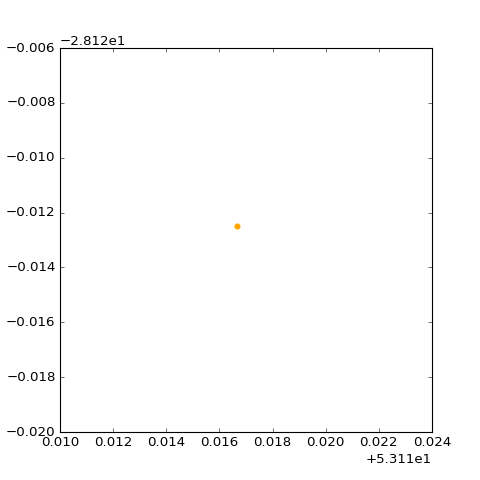

In [5]:
r = '03 32 30.4'
d = '-28 07 57'
c = SkyCoord(ra=r, dec=d, unit=(u.hourangle, u.deg))
r,d = c.ra.degree,c.dec.degree
print r,d


%matplotlib notebook
plt.figure(figsize=(6,6))
a = plt.subplot(111)
#plt.scatter(c1.ra.degree,c1.dec.degree)
#plt.scatter(c1.ra.degree,c2.dec.degree)
#plt.scatter(c2.ra.degree,c1.dec.degree)
#plt.scatter(c2.ra.degree,c2.dec.degree)
plt.scatter(r,d,color='orange')
circle = plt.Circle((r,d), 0.45, color='r',fill=False)
a.add_artist(circle)
#plt.xlim(r-0.5,r+0.5)
#plt.ylim(d-0.5,d+0.5)
plt.show()

In [6]:
# Get all targets within pointing:
targets = get_targets([r],[d],0.8,'LADUMA','LADUMA')

I've done  1  of  1  total pointings


In [28]:
m = find_exoplanets([r],[d],0.8)
m

,pl_hostname,pl_letter,pl_name,pl_discmethod,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,...,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radn,pl_nnotes,rowupdate,pl_facility,NAME_LOWERCASE


<IPython.core.display.Javascript object>


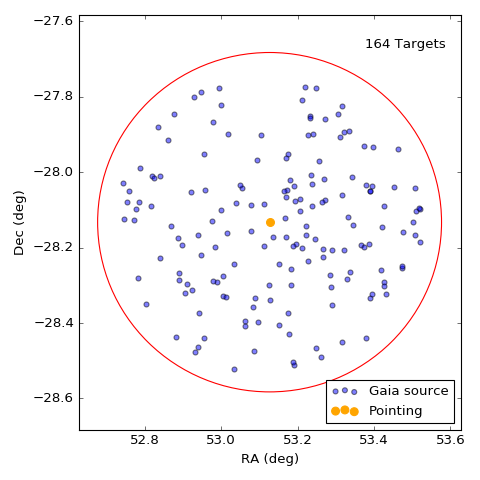

In [29]:
t1=targets
%matplotlib notebook
plt.figure(figsize=(6,6))
a = plt.subplot(111)
plt.scatter(t1['ra'],t1['decl'],alpha=0.5,label='Gaia source')
plt.scatter(r,d,color='orange',s=50,label='Pointing')
#plt.scatter(m['ra'].values[0],m['dec'].values[0],color='orange',marker='*',s=200,label='Exoplanet Host')
plt.annotate("{0} Targets".format(t1['ra'].shape[0]),xy=(0.75,0.92),xycoords='axes fraction')
circle = plt.Circle((r,d), 0.45, color='r',fill=False)
a.add_artist(circle)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.xlim(r-0.5,r+0.5)
plt.ylim(d-0.55,d+0.55)
plt.tight_layout()
plt.legend(fontsize=12,loc=4)
plt.show() 
plt.savefig('laduma_pointing.png',format='png')

<IPython.core.display.Javascript object>


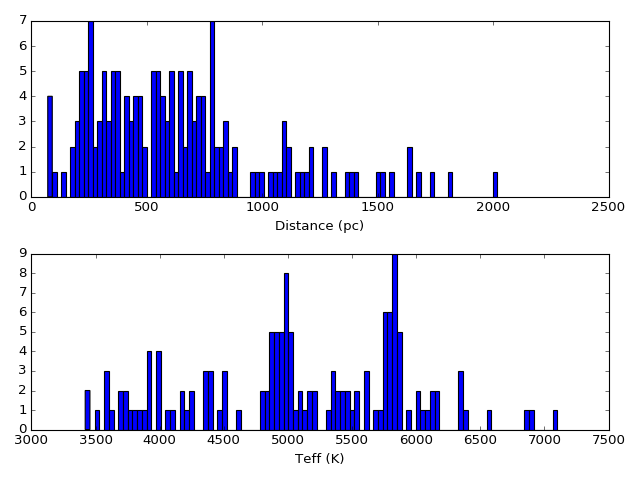

In [30]:
%matplotlib notebook
plt.subplot(211)
plt.hist(t1['dist.c'],bins=100)
plt.xlabel('Distance (pc)')
plt.subplot(212)
plt.hist(t1['teff_val'][np.where(t1['teff_val']!=0)[0]],bins=100)
plt.xlabel('Teff (K)')
plt.tight_layout()
plt.show()
plt.savefig('laduma_dist_teff.png',format='png')

In [8]:
targets.to_csv('../Our_targets/laduma.csv',index=False)

In [6]:
t1=pd.read_csv('../Our_targets/laduma.csv')
t1.shape

(164, 57)

In [21]:
t2=pd.read_csv('1533075441448O-result.csv')
t2=t2.rename(columns={'random_index':'Ind'})
t2['frac_para_error']=t2['parallax_error'].values/t2['parallax']
t2=t2.rename(columns={'dec':'decl','bp_g':'bp_G','g_rp':'G_rp','phot_g_mean_flux_error':'phto_g_mean_flux_error'})
cols=['Ind', 'source_id', 'ref_epoch', 'ra', 'ra_error', 'decl', 'dec_error', 'parallax', 'parallax_error', \
      'parallax_over_error', 'frac_para_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'astrometric_n_obs_al',\
      'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'visibility_periods_used', \
      'phot_g_n_obs', 'phot_g_mean_flux', 'phto_g_mean_flux_error', 'phot_g_mean_flux_over_error', 'phot_g_mean_mag', \
      'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'bp_G', 'G_rp', 'radial_velocity', 'radial_velocity_error', \
      'l', 'b', 'ecl_lat', 'ecl_lon', 'priam_flags', 'teff_val', 'teff_percentile_lower', 'teff_percentile_upper', \
      'a_g_val', 'a_g_percentile_lower', 'a_g_percentile_upper', 'radius_val', 'radius_percentile_upper', \
      'radius_percentile_lower', 'lum_val', 'lum_percentile_upper', 'lum_percentile_lower']
t2=t2[cols]
t2['dist.c'],t2['fwhm_lo.c'],t2['fwhm_hi.c'],t2['sd.c'],t2['teff_val.c'],t2['sptype.c']='NaN','NaN','NaN','NaN',\
                                                                                        'NaN','NaN'
t2['project'],t2['name']='LADUMA','LADUMA'
t2.shape

(1597, 57)

In [22]:
#t2 = pd.read_csv('laduma_no_quality_cut.csv')
#t2['project']='LADUMA'
#t2['NAME']='LADUMA'
t2.to_csv('../Our_targets/laduma_no_quality_cut.csv',index=False)

<IPython.core.display.Javascript object>


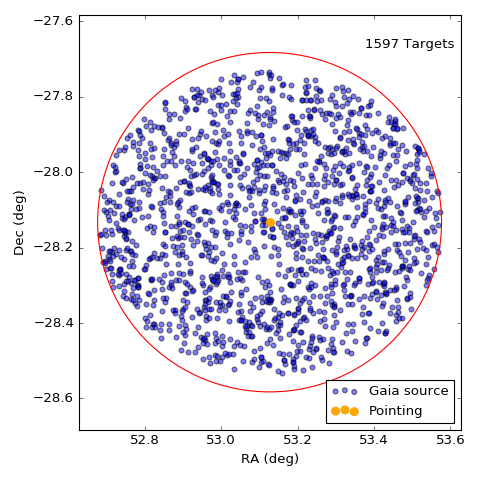

In [33]:
%matplotlib notebook
plt.figure(figsize=(6,6))
a = plt.subplot(111)
plt.scatter(t2['ra'],t2['dec'],alpha=0.5,label='Gaia source')
plt.scatter(r,d,color='orange',s=50,label='Pointing')
#plt.scatter(m['ra'].values[0],m['dec'].values[0],color='orange',marker='*',s=200,label='Exoplanet Host')
plt.annotate("{0} Targets".format(t2['ra'].shape[0]),xy=(0.75,0.92),xycoords='axes fraction')
circle = plt.Circle((r,d), 0.45, color='r',fill=False)
a.add_artist(circle)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.xlim(r-0.5,r+0.5)
plt.ylim(d-0.55,d+0.55)
plt.tight_layout()
plt.legend(fontsize=12,loc=4)
plt.show() 